<a href="https://colab.research.google.com/github/LoveTechCode/Modulo1/blob/master/Ejercicio_1_Modulo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importamos las librerias necesarias

In [ ]:
from __future__ import print_function
 
import math

from IPython import display # IPython añade funcionalidades extras, resaltado de codigo, autocompletado..
from matplotlib import cm  # para mapas de color 
from matplotlib import gridspec #permite crear graficos en subparcelas independientes
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
from sklearn import metrics # implementa funciones para evaluar el error de nuestro modelo
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
 
tf.logging.set_verbosity(tf.logging.ERROR) # configuración de errores por pantalla
pd.options.display.max_rows = 10 #maximo de filas cuando imprimimos datos
pd.options.display.float_format = '{:.1f}'.format

##Preparamos nuestros datos de entrada

In [ ]:
Tasa = [0.10, 0.15, 0.25,0.50,0.75,0.80,1.0,1.25,1.75]
Accidentes = [6,4,8,10,15,25,30,40,45]

datos_dataframe = pd.DataFrame()
datos_dataframe['Tasa'] = Tasa
datos_dataframe['Accidentes'] = Accidentes
datos_dataframe['Accidentes'] /=100

# Definimos la característica de entrada: total_rooms.
mi_caracteristica_input = datos_dataframe[["Tasa"]]

# Configuramos la columna de atributos como númerica
columna_atributos = [tf.feature_column.numeric_column("Tasa")]

# Definimos nuestro objetivo
objetivo_median_house_value = datos_dataframe["Accidentes"]


## Definimos la funcion de entrada

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=100):
    """Entrenamiento de un modelo Lineal 
  
    Args:
      features: Un DataFrame de Pandas
      targets: DataFrame de objetivos Pandas.
      batch_size: Tamaño del lote que le pasamos al modelo
      shuffle: True or False. Sirve para mezclar los datos
      num_epochs: Numero de epochs
   
    """
  
    # Convierte los datos de Pandas en un diccionario de matrices O TENSOR
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Creamos un nuevo dataset cuyos elementos son trozos del tensor (fetaures, targets). 
    # El tensor se trocea a lo largo de su primera dimension.
    ds = Dataset.from_tensor_slices((features,targets)) # maximo 2GB
    ds = ds.batch(batch_size).repeat(num_epochs)
    
 
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # construye una variable de iteración para el conjunto de datos y devuelve el siguiente lote de datos al regresor lineal
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

##Preparamos el modelo

In [ ]:
def train_model(learning_rate, steps, batch_size, input_feature="Tasa"):
  """Entrena un modelo de Regresión Lineal de una caracteristica.
  
  Args:
    learning_rate: tasa de aprendizaje
    steps: pasos del entrenamiento
    batch_size: Tamaño del lote.
    input_feature: Un String que especifica una columna`datos
_dataframe`
      para usar como caracteristica de entrada
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = datos_dataframe[[my_feature]]
  my_label = "Accidentes"
  targets = datos_dataframe[my_label]

  # Damos formato numerico a los valores de la columna
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Definimos las funciones input_fn para el modelo
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda:my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Construimos el optimizador y el estimador
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Preparamos la representacion grafica de los resultados
  # Representacion de la grafica izquierda del frame
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = datos_dataframe.sample(n=9)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Entrenamos el modelo dentro de un bucle para evaluar perdidas periodicamente

  print("Entrenando el modelo...")
  print("RMSE (en datos de entrenamiento):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # 
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Toma un descanso y computa predicciones
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Computa perdidas.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    
    # Ocasionalmente imprime la perdida actual
    print("  periodo %02d : %0.2f" % (period, root_mean_squared_error))
    
    # Agrega las metricas de perdida de este periodo a nuestra lista
    root_mean_squared_errors.append(root_mean_squared_error)
    
    # Finalmente, realiza un seguimiento de los pesos y los sesgos a lo largo del tiempo. 
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period])

  print("Entrenamiento del modelo Finalizado.")

  # Genera el grafico de metricas
  # Representacion de la grafica derecha del frame
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periodos')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Pinta la tabla con los datos de calibración.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  

##Entrenamos


In [ ]:
train_model(
    learning_rate=0.001,
    steps=900000,
    batch_size=9
)

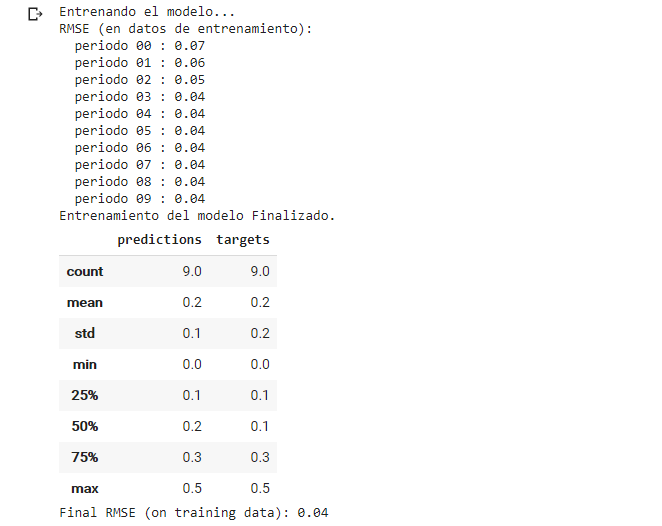

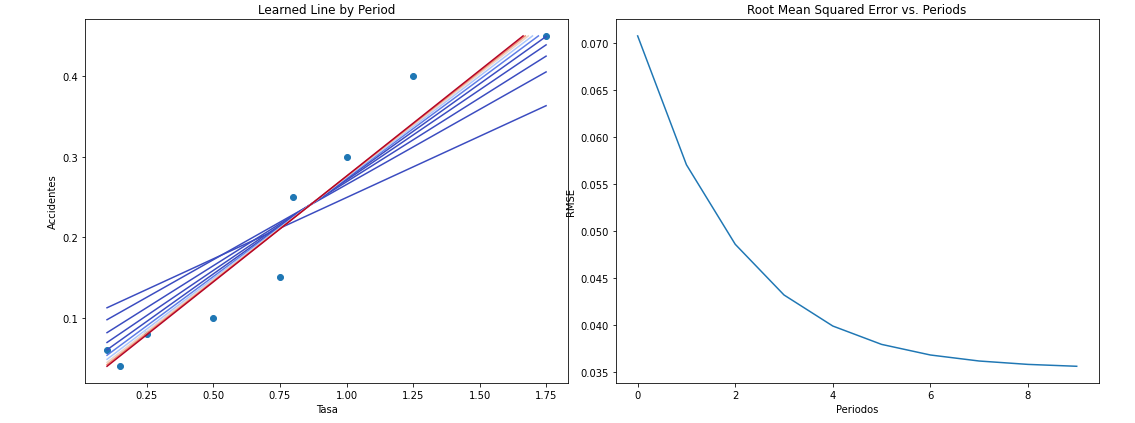